In [1]:
import os
from dotenv import load_dotenv
import requests
import pandas as pd
import matplotlib.pyplot as plt
from googleapiclient.discovery import build

In [2]:
load_dotenv()
API_KEY = os.getenv("API_KEY")

channel_id = "UC7cs8q-gJRlGwj4A8OmCmXg"   # Put The Desired Channel's ID Here

In [3]:
# Getting All Playlists' IDs For The Channel:

playlists_ids= dict()

api_service_name = "youtube"
api_version = "v3"

youtube = build(api_service_name, api_version, developerKey= API_KEY)

request = youtube.playlists().list(
    part= "snippet,contentDetails",
    channelId= channel_id,
    maxResults= 50
)

response = request.execute()    # "response" is a Dictionary

for item in response["items"]:  # "items" is a List of Dictionaries
    playlists_ids[item.get("snippet").get("title")] = item.get("id")

In [4]:
# Getting Videos IDs For Each Playlist: 

playlist_videos_ids = dict()

api_service_name = "youtube"
api_version = "v3"

youtube= build(api_service_name, api_version, developerKey= API_KEY)

for playlist_name, playlist_id in playlists_ids.items():
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        maxResults=100,
        playlistId= playlist_id
    )

    response = request.execute()

    videos_IDs = []
    for item in response["items"]:
        video_id = item["contentDetails"]["videoId"]    # "contentDetails" is a Dictionary, "videoId" is the key and we want its value
        videos_IDs.append(video_id)

    playlist_videos_ids[playlist_name] = {"playlist_id": playlist_id, "videos_ids": videos_IDs}

In [5]:
# Getting Data About Playlist Videos (Views Count - Likes Count): 

playlists_data = dict()

api_service_name = "youtube"
api_version = "v3"

youtube = build(api_service_name, api_version,developerKey= API_KEY)

numeber_of_unfound_videos = 0
for playlist_name, playlist_data in playlist_videos_ids.items():
    total_playlist_views = 0
    likes_per_views_percentages = []
    
    for video_id in playlist_data["videos_ids"]:
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id= video_id
        )
        response = request.execute()

        
        if response.get("items"):
            video_data = response.get("items")[0]
            
            views = int(video_data["statistics"].get("viewCount"))
            likes = int(video_data["statistics"].get("likeCount"))
            likes_per_views_percentage = (likes/views) * 100

            total_playlist_views += views
            likes_per_views_percentages.append(likes_per_views_percentage)
        
        else: numeber_of_unfound_videos +=1


    mean_likes_per_views_percentage = round(sum(likes_per_views_percentages) / len(likes_per_views_percentages),2)
    playlists_data[playlist_name] = {"Total Views": total_playlist_views, "Likes Per Views Percentage": mean_likes_per_views_percentage}

print(f"{numeber_of_unfound_videos} Videos Are Private Or Unfound !!")

0 Videos Are Private Or Unfound !!


In [6]:
# Normalizing a Score For Each Metric: 

views_numbers = [data["Total Views"] for data in playlists_data.values()]
likes_percentage_numbers = [data["Likes Per Views Percentage"] for data in playlists_data.values()]

max_playlist_views = max(views_numbers)
min_playlist_views = min(views_numbers)

max_likes_percentage = max(likes_percentage_numbers)
min_likes_percentage = min(likes_percentage_numbers)

In [7]:
# Getting a Final Score For Each Playlist:

playlists_final_score = dict()

views_weight = 0.7
likes_weight = 0.3

for playlist_name, playlist_data in playlists_data.items():
    views_score = ((( (playlist_data["Total Views"] - min_playlist_views) / (max_playlist_views - min_playlist_views) ) * 9) + 1 ) * views_weight
    likes_score = ((( (playlist_data["Likes Per Views Percentage"] - min_likes_percentage) / (max_likes_percentage - min_likes_percentage) ) * 9) + 1 ) * likes_weight

    final_score = round(views_score + likes_score,2)
    playlists_final_score[playlist_name] = final_score

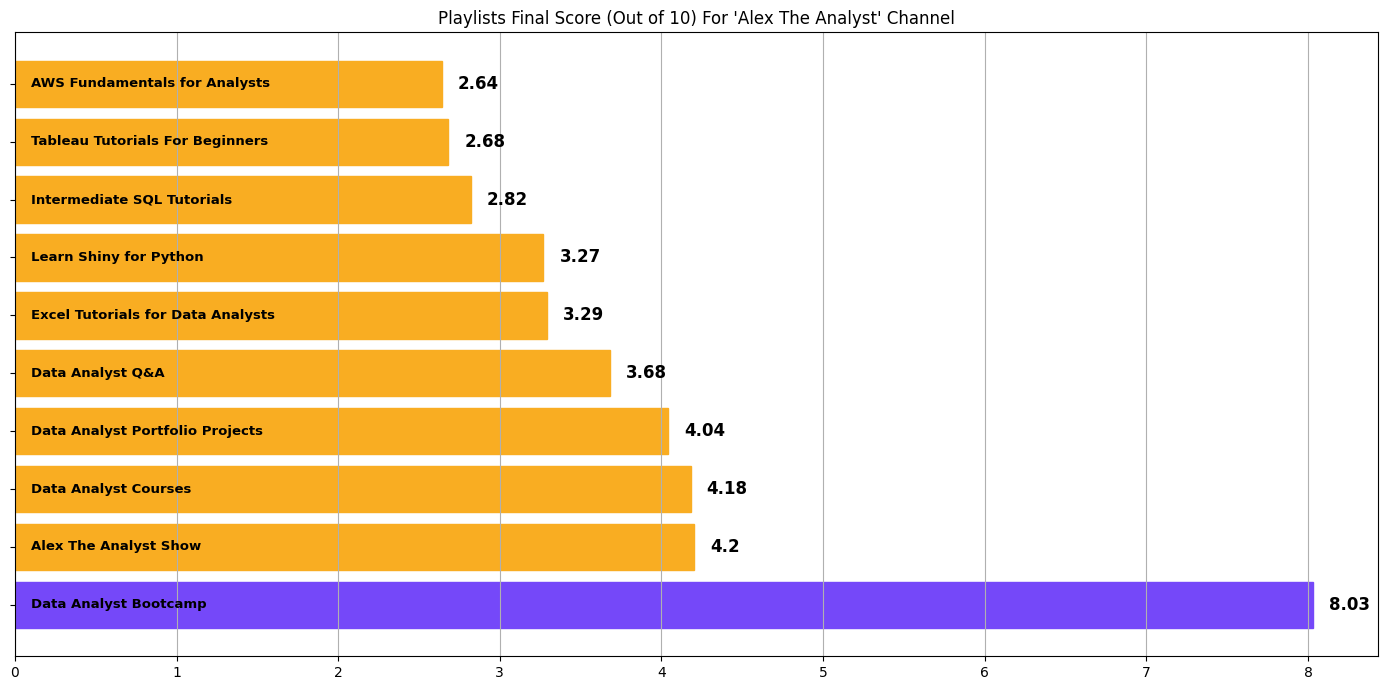

In [8]:
# Plotting The Result Using Matplotlib:

playlists_final_score_df = pd.DataFrame(list(playlists_final_score.items()), columns=["Playlist", "Final Score"])
playlists_final_score_df = playlists_final_score_df.sort_values(by="Final Score", ascending=False).head(10)   # Getting Top 10 Playlists

plt.figure(figsize=(14,7))
plot = plt.barh(playlists_final_score_df["Playlist"], playlists_final_score_df["Final Score"])

# Iterate Over Each Bar To Manage Text And Color:
for idx, bar in enumerate(plot):
    final_score = playlists_final_score_df["Final Score"].iloc[idx]

    if final_score >= 8:
        bar.set_color("#7548f9")
    elif 5 <= final_score < 8:
        bar.set_color("#1da757")
    else:
        bar.set_color("#f9ad22")
    

    # Get The Bar Width And Place The Label Accordingly:
    x_value = bar.get_width()
    y_value = bar.get_y() + bar.get_height() / 2  # Center Vertically Within The Bar
    
    plt.text(
        x=x_value + 0.1,
        y=y_value,
        s=x_value,
        ha="left",
        va="center",
        fontsize=12,
        fontweight="bold",
        fontname = "DejaVu Sans",
        color="black"
    )


# Move Playlist Names Inside The Plot:
ax = plt.gca()  # Get Current Axes
ax.set_yticklabels([])  # Hides The Original Y-axis Labels.

for idx, playlist_name in enumerate(playlists_final_score_df["Playlist"]):
    y_value = idx  # Use the index for y-value
    plt.text(
        x=0.1,
        y=y_value,
        s=playlist_name,
        ha="left",
        va="center",
        fontsize=9.5,
        fontweight="bold",
        fontname = "DejaVu Sans",
        color="black"
    )


# Getting Channel's Name: 
api_service_name = "youtube"
api_version = "v3"
youtube = build(api_service_name, api_version, developerKey= API_KEY)

request = youtube.channels().list(
    part="snippet,contentDetails,statistics",
    id= channel_id
)
response = request.execute()
channel_name = response["items"][0]["snippet"].get("title")

plt.title(f"Playlists Final Score (Out of 10) For '{channel_name}' Channel")
plt.grid(axis="x")
plt.tight_layout()
plt.show()
